In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
from shapely.geometry import Point 
import json

sns.set()

In [2]:
st = pd.read_csv("/Users/katherinementzer/SFUSD/Data/Cleaned/drop_optout_1819.csv")
st = st.loc[st.grade == "KG"]
st["frl"] = st.freelunch_prob + st.reducedlunch_prob
progs = pd.read_csv("/Users/katherinementzer/SFUSD/Data/Cleaned/programs_1819.csv")
sch = pd.read_csv("/Users/katherinementzer/SFUSD/Data/Cleaned/schools_rehauled_1819.csv")
geo = [Point(xy) for xy in zip(sch['lon'], sch['lat'])]
sch = gpd.GeoDataFrame(sch, geometry=geo, crs='epsg:4326')

In [3]:
path = os.path.expanduser('~/SFUSD/Census 2010_ Blocks for San Francisco/geo_export_d4e9e90c-ff77-4dc9-a766-6a1a7f7d9f9c.shp')
sf = gpd.read_file(path)
sf['geoid10'] = sf['geoid10'].fillna(value=0).astype('int64', copy=False)
tmp = pd.read_csv('~/Dropbox/SFUSD/Optimization/block_blockgroup_tract.csv')
tmp['Block'] = tmp['Block'].fillna(value=0).astype('int64', copy=False)
sf = sf.merge(tmp,how='left',left_on='geoid10',right_on='Block')
sf = sf.dissolve(by="BlockGroup", as_index=False)
sf = sf.to_crs('epsg:4326')

In [8]:
assignment = "dist4_maxfrl1_alpha1_card0_umodelavg"
df = pd.read_csv(
    f"/Users/katherinementzer/Documents/sfusd/local_runs/assignments/Assignment_CTIP0_round_merged123_policy{assignment}home_based_peng_tiesSTB_iteration14.csv"
)
df = st.merge(df, on="studentno")

path = f"/Users/katherinementzer/Documents/sfusd/local_runs/Zones/peng_menu_{assignment}.json"
with open(path, "r") as f:
    menus = json.load(f)

In [137]:
unassigned = df.loc[df.programno == 0]
unassigned = pd.get_dummies(unassigned, columns=["resolved_ethnicity"], prefix="", prefix_sep="")

In [138]:
unassigned[
    [
        "frl",
        "Asian",
        "Black or African American",
        "Decline to State",
#         "Filipino",
        "Hispanic/Latino",
#         "Two or More Races",
#         "Vietnamese",
        "White",
    ]
].mean()

frl                          0.429381
Asian                        0.240901
Black or African American    0.027730
Decline to State             0.195841
Hispanic/Latino              0.204506
White                        0.164645
dtype: float64

**Observation:** Unassigned students are lower FRL and more white

<AxesSubplot:>

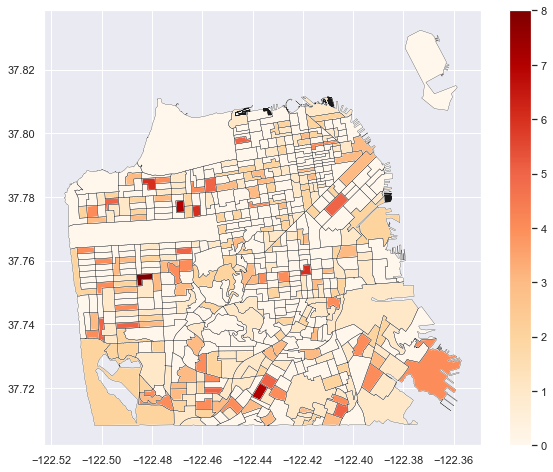

In [139]:
plt.figure(figsize=(10,8))
ax = plt.gca()
sf.boundary.plot(ax=ax, lw=.3, color="k")
sf.merge(
    unassigned.groupby("census_blockgroup").count(),
    how="left",
    left_on="BlockGroup",
    right_index=True,
).fillna(0).plot(ax=ax, column="studentno", cmap="OrRd", legend=True)

In [140]:
counts = {}
menu_len = []
for studentno in unassigned.studentno:
    if str(studentno) not in menus:
        print(f"no menu for{studentno}")
        continue
    menu_len.append(len(menus[str(studentno)]))
#     print(menus[str(studentno)])
    for p in menus[str(studentno)]:
        counts[p] = counts.get(p, 0) + 1

In [141]:
np.mean(menu_len)

37.84402079722704

In [142]:
counts

{'449-GE-KG': 515,
 '478-GE-KG': 558,
 '479-KE-KG': 551,
 '507-GE-KG': 443,
 '509-CE-KG': 556,
 '513-CB-KG': 561,
 '539-GE-KG': 515,
 '562-CN-KG': 515,
 '562-GE-KG': 515,
 '575-SB-KG': 515,
 '603-GE-KG': 448,
 '603-SB-KG': 446,
 '614-GE-KG': 552,
 '644-GE-KG': 436,
 '656-SB-KG': 512,
 '664-GE-KG': 512,
 '680-SE-KG': 482,
 '723-SB-KG': 438,
 '729-SE-KG': 433,
 '729-SN-KG': 465,
 '782-GE-KG': 512,
 '786-GE-KG': 462,
 '816-GE-KG': 464,
 '838-GE-KG': 533,
 '838-MN-KG': 463,
 '838-SA-KG': 541,
 '513-SB-KG': 402,
 '691-GE-KG': 422,
 '714-SN-KG': 401,
 '420-SE-KG': 195,
 '420-SN-KG': 266,
 '453-SE-KG': 206,
 '453-SN-KG': 238,
 '478-JN-KG': 267,
 '485-CE-KG': 170,
 '485-CT-KG': 294,
 '490-GE-KG': 391,
 '505-GE-KG': 319,
 '513-GE-KG': 266,
 '525-GE-KG': 168,
 '537-MS-KG': 130,
 '562-AF-KG': 342,
 '569-GE-KG': 161,
 '618-SE-KG': 138,
 '644-AF-KG': 165,
 '670-AF-KG': 162,
 '680-SN-KG': 126,
 '691-MM-KG': 154,
 '691-SB-KG': 140,
 '722-AF-KG': 350,
 '723-GE-KG': 184,
 '724-NS-KG': 148,
 '750-SA-KG'

In [143]:
counts_sch = {int(k[:3]): v for k, v in counts.items()}

In [144]:
sch["on_menu"] = sch.school_id.apply(lambda x: counts_sch[x] if x in counts_sch else 0)

**Observations:** 
- All options on menus are GE!!
- All unassigned get exactly one menu option mostly to popular schools! 

<AxesSubplot:>

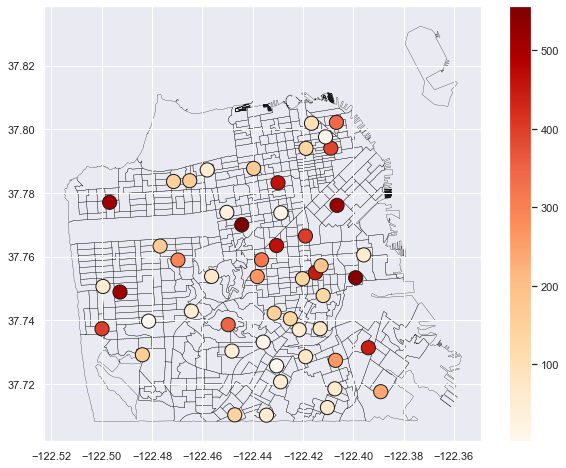

In [145]:
plt.figure(figsize=(10,8))
ax = plt.gca()
sf.boundary.plot(ax=ax, lw=.3, color="k", zorder=0)
sch.loc[sch.on_menu >0].plot(ax=ax, column="on_menu", cmap="OrRd", legend=True, edgecolor="k", markersize=200)

In [146]:
tot_counts = {}
for studentno in df.studentno:
    if str(studentno) not in menus:
        print(f"no menu for{studentno}")
        continue
    for p in menus[str(studentno)]:
        tot_counts[p] = tot_counts.get(p, 0) + 1

In [147]:
tot_counts

{'449-GE-KG': 2771,
 '478-GE-KG': 3565,
 '479-KE-KG': 3534,
 '507-GE-KG': 2608,
 '509-CE-KG': 3542,
 '513-CB-KG': 3459,
 '539-GE-KG': 2755,
 '562-CN-KG': 2678,
 '562-GE-KG': 2694,
 '575-SB-KG': 2699,
 '603-GE-KG': 1997,
 '603-SB-KG': 1924,
 '614-GE-KG': 3550,
 '644-GE-KG': 1777,
 '656-SB-KG': 2675,
 '664-GE-KG': 2710,
 '680-SE-KG': 1904,
 '723-SB-KG': 1858,
 '729-SE-KG': 2048,
 '729-SN-KG': 2066,
 '782-GE-KG': 2688,
 '786-GE-KG': 2615,
 '816-GE-KG': 2569,
 '838-GE-KG': 3401,
 '838-MN-KG': 2582,
 '838-SA-KG': 3433,
 '729-GE-KG': 57,
 '413-SA-KG': 2014,
 '420-MS-KG': 2011,
 '420-SE-KG': 2141,
 '420-SN-KG': 2319,
 '453-GE-KG': 2149,
 '453-SE-KG': 2122,
 '453-SN-KG': 2205,
 '456-GE-KG': 2093,
 '476-NC-KG': 2128,
 '478-JN-KG': 2251,
 '478-MM-KG': 2023,
 '479-KN-KG': 1957,
 '481-GE-KG': 1947,
 '488-GE-KG': 1833,
 '490-CB-KG': 2078,
 '490-GE-KG': 2534,
 '497-GE-KG': 1885,
 '497-SE-KG': 1971,
 '497-SN-KG': 2362,
 '505-GE-KG': 2381,
 '513-GE-KG': 2277,
 '513-SB-KG': 2514,
 '521-GE-KG': 2365,
 '

In [148]:
ge_sch_counts = {int(k[:3]): v for k, v in tot_counts.items() if k[4:6] == "GE"}

In [149]:
sch["tot_on_menu"] = sch.school_id.apply(lambda x: ge_sch_counts[x] if x in ge_sch_counts else 0)
ge_cap = dict(zip(progs.loc[progs.program_type == "GE"].school_id, progs.loc[progs.program_type == "GE"].capacity))
sch["menu_per_seat"] = sch.school_id.apply(lambda x: ge_sch_counts[int(x)]/ge_cap[x] if x in ge_sch_counts else 0)

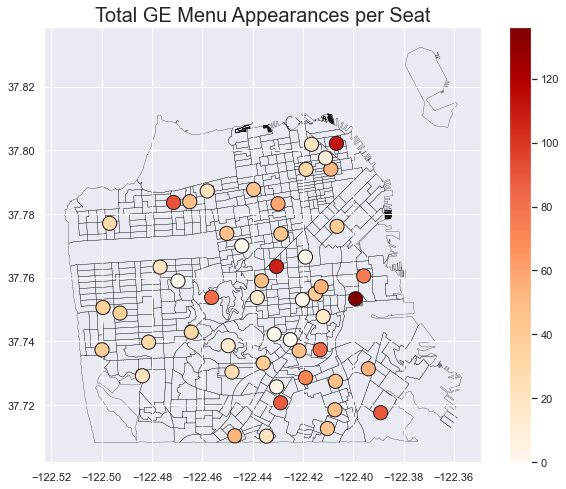

In [150]:
plt.figure(figsize=(10,8))
ax = plt.gca()
sf.boundary.plot(ax=ax, lw=.3, color="k", zorder=0)
sch.loc[sch.on_menu >0].plot(ax=ax, column="menu_per_seat", cmap="OrRd", legend=True, edgecolor="k", markersize=200)
plt.title("Total GE Menu Appearances per Seat", fontsize=20)
plt.show()

In [151]:
df["ge"] = df.programcodes.apply(lambda x: x[4:6] == "GE" if not pd.isna(x) else False)
progs = progs.merge(
    df.loc[df["ge"]].groupby("programcodes").count()[["studentno"]],
    how="left",
    left_on="program_id",
    right_index=True
)
progs["ge_seats_remaining"] = progs.capacity - progs.studentno
sch = sch.merge(
    progs[["school_id", "ge_seats_remaining"]],
    how="left",
    on="school_id"
)

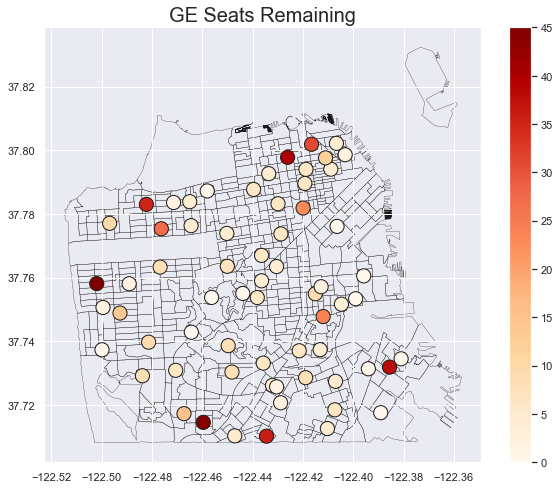

In [152]:
plt.figure(figsize=(10,8))
ax = plt.gca()
sf.boundary.plot(ax=ax, lw=.3, color="k", zorder=0)
sch.plot(ax=ax, column="ge_seats_remaining", cmap="OrRd", legend=True, edgecolor="k", markersize=200, vmin=0)
plt.title("GE Seats Remaining", fontsize=20)
plt.show()

In [22]:
pid = "435-GE-KG"
progs.loc[progs.program_id == pid][["program_id", "capacity"]]

,program_id,capacity
6,435-GE-KG,92


In [23]:
df.loc[df.programcodes == pid].groupby("programcodes").count()[["studentno"]]

,studentno
programcodes,
435-GE-KG,84


In [7]:
siblings = pd.read_csv("klm_raw_inputs/preassigned_siblings.csv")

In [25]:
len(unassigned), len(siblings), len(unassigned.merge(siblings))

(144, 1190, 5)

In [26]:
df.dropna(subset=["sibling"])[["studentno", "sibling"]]

,studentno,sibling
1,10210006,[729]
7,10210058,[872]
22,10210137,[509]
25,10210149,[509]
27,10210160,[676]
...,...,...
4748,888009715,[449]
4758,888020901,[509]
4760,888021277,[656]
4761,888021301,[525]


In [27]:
unassigned[["sibling"]]

,sibling
5,NaN
6,NaN
51,NaN
70,NaN
136,NaN
...,...
4637,NaN
4672,NaN
4674,NaN
4699,NaN


In [28]:
pd.set_option('display.max_rows', 500)

In [29]:
df.groupby("programcodes").mean()[["frl"]].sort_values("frl", ascending=False).head(15)

,frl
programcodes,
823-AF-KG,0.888889
490-CB-KG,0.773448
650-SB-KG,0.755620
562-CN-KG,0.729237
638-CB-KG,0.728430
872-CB-KG,0.728336
490-GE-KG,0.715804
603-SB-KG,0.715223
867-CB-KG,0.713877


**Observation:** almost none of the violating programs are GE

In [30]:
df["count"] = 1
df.loc[df.programcodes == "490-GE-KG"].groupby("programcodes").sum()[["count", "frl"]].merge(
    progs[["program_id", "capacity"]],
    left_index=True,
    right_on="program_id"
)

,count,frl,program_id,capacity
72,44,30.779577,490-GE-KG,48


In [31]:
util = np.load("base_utility.npy")

In [32]:
util

array([[43.10178176, 43.10178176, 42.70378539, ..., -1.        ,
        42.27919981, -1.        ],
       [43.09350383, 43.09350383, 42.79905897, ..., 43.62166564,
        42.34166564, -1.        ],
       [43.09350383, 43.09350383, 42.79905897, ..., -1.        ,
        42.34166564, -1.        ],
       ...,
       [40.69565612, 40.69565612, 42.09578814, ..., -1.        ,
        41.7838788 , -1.        ],
       [40.69565612, 40.69565612, 42.09578814, ..., -1.        ,
        41.7838788 , -1.        ],
       [41.70976946, 41.70976946, 43.39070306, ..., -1.        ,
        42.69875088, -1.        ]])

In [33]:
df.loc[df.programcodes == "490-GE-KG"].mean()

/Users/katherinementzer/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


Unnamed: 0                   1.166600e+04
studentno                    4.690668e+08
randomnumber                 5.807405e-01
requestprogramdesignation    9.090909e-02
latitude                     3.777925e+01
longitude                   -1.224117e+02
r1_idschool                  5.534048e+02
r1_rank                      1.785714e+00
r1_isdesignation             2.380952e-02
r1_distance                  1.323095e+00
ctip1                        6.818182e-02
idschoolattendance           6.226591e+02
r3_idschool                  5.471220e+02
r3_rank                      1.000000e+00
r3_isdesignation             0.000000e+00
r3_distance                  1.279024e+00
zipcode                      9.411964e+04
disability                            NaN
enrolled_idschool            5.444524e+02
math_scalescore                       NaN
ela_scalescore                        NaN
r2_idschool                  4.625000e+02
final_school                 5.501136e+02
num_ranked                   6.227

In [34]:
sch.loc[sch.school_id == 490]

,school_id,school_name,school_name_long,lat,lon,zip,category,grades,cap_lb,eng_scores_1819,...,AvgColorIndex,attendance_area,Block,BlockGroup,Tract,geometry,on_menu,tot_on_menu,menu_per_seat,ge_seats_remaining
35,490,Lau ES (PK-5),Gordon J. Lau Elementary School,37.794079,-122.408925,94108,Attendance,PK-5th,118,2448.358974,...,4.5,490,60750113002001,60750113002,6.075011e+09,POINT (-122.40892 37.79408),6,2351,48.979167,NaN
36,490,Lau ES (PK-5),Gordon J. Lau Elementary School,37.794079,-122.408925,94108,Attendance,PK-5th,118,2448.358974,...,4.5,490,60750113002001,60750113002,6.075011e+09,POINT (-122.40892 37.79408),6,2351,48.979167,4.0


In [9]:
st["lang_match"] = st.homelang_desc.apply(
    lambda x: "spanish"
    if x == "SP-Spanish"
    else ("cantonese" if x == "CC-Chinese Cantonese" else "no_match")
)
st["type"] = st.apply(
    lambda x: f"{x.lang_match}-{int(x.census_blockgroup)}"
    if not pd.isna(x.lang_match) and not pd.isna(x.census_blockgroup)
    else np.nan,
    axis=1
)
st[["census_blockgroup", "homelang_desc", "type"]]

,census_blockgroup,homelang_desc,type
5531,6.075033e+10,EN-English,no_match-60750332042
5532,6.075026e+10,EN-English,no_match-60750264023
5533,6.075016e+10,EN-English,no_match-60750157001
5534,6.075020e+10,EN-English,no_match-60750204011
5536,6.075031e+10,SP-Spanish,spanish-60750314002
...,...,...,...
14950,6.075023e+10,SP-Spanish,spanish-60750232002
14951,6.075043e+10,SP-Spanish,spanish-60750426011
14955,6.075012e+10,PA-Pashto,no_match-60750120001
14957,6.075026e+10,SP-Spanish,spanish-60750260031


In [12]:
base_utilities = np.load("/Users/katherinementzer/Dropbox/SFUSD/Choice_Model/Oct1estimates.npy")
base_utilities += 50
base_utilities[np.isneginf(base_utilities)] = -1

In [13]:
base_utilities

array([[43.67564756, 38.18843846, 43.50810483, ..., 35.15717741,
        -1.        , -1.        ],
       [42.52102833, 37.03381923, 43.58027682, ..., 35.54163995,
        43.35074992, 44.0064458 ],
       [45.48909229, 40.00188319, 44.86414938, ..., 38.41026114,
        45.41615501, 46.07185089],
       ...,
       [44.33567871, 38.84846961, 44.11911152, ..., 39.73155254,
        -1.        , -1.        ],
       [43.14254963, 37.65534053, 44.30378457, ..., 35.75575184,
        -1.        , -1.        ],
       [41.97697638, 36.48976728, 43.11668114, ..., 35.28153522,
        -1.        , -1.        ]])

In [15]:
ref2 = pd.read_csv("klm_raw_inputs/typecodes.csv", index_col=0)[
    ["census_blockgroup", "lang_match"]
]
type2def = {f"{row.lang_match}-{row.census_blockgroup}": typecode for typecode, row in ref2.iterrows()}
st["t"] = st.type.apply(lambda x: int(type2def[x]) if not pd.isna(x) and x in type2def else np.nan)

In [16]:
siblings = pd.read_csv("klm_raw_inputs/preassigned_siblings.csv")
df = pd.merge(st, siblings, on="studentno", how="outer", indicator=True)
df = df[df['_merge'] == 'left_only']

In [17]:
df.reset_index(drop=True).reset_index().groupby("t").index.agg(list)

t
0.0                       [789, 3024]
1.0                       [469, 2914]
2.0      [250, 778, 1397, 3160, 3184]
3.0                       [892, 1843]
4.0                [1814, 2006, 3407]
                     ...             
917.0                          [2724]
918.0              [1519, 2651, 3188]
919.0         [784, 1315, 1533, 2426]
920.0                          [3280]
921.0                [29, 1029, 1354]
Name: index, Length: 922, dtype: object

In [18]:
type_utilities = np.zeros((922, 159))
idx_df = df.reset_index(drop=True).reset_index().groupby("t").index.agg(list)
for t, idx_list in dict(idx_df).items():
    for i in idx_list:
        type_utilities[int(t), :] += base_utilities[i, :]
    type_utilities[int(t), :] /= len(idx_list)
type_utilities = np.hstack([type_utilities, -5 * np.ones((type_utilities.shape[0], 1))])

In [19]:
# np.save("avg_base_utilities_bigpenalty.npy", type_utilities)
# np.save("avg_base_utilities_bigpenalty.npy", type_utilities)
np.save("avg_base_utilities2.npy", type_utilities)

In [14]:
type_utilities

array([[43.18328062, 37.69607152, 44.65397143, ..., 19.18925874,
        19.51710669, -5.        ],
       [44.7908447 , 39.3036356 , 44.63336904, ..., 45.63289263,
        46.28858851, -5.        ],
       [44.10861179, 38.62140269, 44.31423746, ..., 35.52049529,
        36.04505199, -5.        ],
       ...,
       [43.38003705, 37.89282795, 44.74096462, ..., 19.64887027,
        19.97671821, -5.        ],
       [44.2469124 , 38.7597033 , 44.75071177, ..., -5.        ,
        -5.        , -5.        ],
       [44.47441749, 38.98720839, 43.83281335, ..., 12.09757982,
        12.31614511, -5.        ]])

In [11]:
orig_type_utilities = np.load("avg_base_utilities.npy")
orig_type_utilities

array([[43.18328062, 37.69607152, 44.65397143, ..., 21.18925874,
        21.51710669, -1.        ],
       [44.7908447 , 39.3036356 , 44.63336904, ..., 45.63289263,
        46.28858851, -1.        ],
       [44.10861179, 38.62140269, 44.31423746, ..., 36.32049529,
        36.84505199, -1.        ],
       ...,
       [43.38003705, 37.89282795, 44.74096462, ..., 21.64887027,
        21.97671821, -1.        ],
       [44.2469124 , 38.7597033 , 44.75071177, ..., -1.        ,
        -1.        , -1.        ],
       [44.47441749, 38.98720839, 43.83281335, ..., 14.76424648,
        14.98281178, -1.        ]])

In [44]:
old_utilities = np.load("base_utility.npy")

In [46]:
diff = type_utilities - old_utilities

In [49]:
diff.mean(axis=0)

array([ 8.81117484e-01, -4.60609162e+00,  4.25231161e-01, -4.94252946e+00,
       -2.94387211e+01,  6.42605104e+00,  3.17278533e-01, -1.44611205e+00,
       -2.93736334e+01,  5.84740878e-01, -2.52690283e+01,  6.93750817e+00,
       -1.54172415e+00,  3.47319048e+01, -4.67521004e+00, -2.84439603e+01,
       -2.68107742e+00, -3.09553804e+01, -2.78001517e+01, -2.67021754e+00,
       -2.88799478e+01, -2.72526348e+01, -2.33909276e+01,  3.78079785e+01,
       -3.71893004e+01, -1.35350546e+00, -1.57719094e+00,  3.31655305e+01,
       -2.85911813e+01,  3.76088611e-01, -2.04346482e+00, -2.42266614e+00,
        2.99243257e+01, -2.92285573e+01, -2.64405795e+01, -2.94362085e+01,
        3.48313592e+01,  5.38440373e+00,  6.67423786e-01, -2.74633819e+01,
        6.15635281e+00, -1.67335507e+00, -2.58010079e+01, -2.60429618e+01,
       -1.26472229e+00,  3.51429685e+01, -5.73160606e+00, -2.90730438e+01,
        2.17571666e+00, -3.31149244e+00, -4.01205885e-01, -2.77764470e+01,
       -1.99565157e+00,  

In [54]:
pc = pd.read_csv("/Users/katherinementzer/SFUSD/program_effects_oct1_choice_model.csv")

In [55]:
pr2c = {row.program.split("_")[1]: row.coefficient for _, row in pc.iterrows()}

In [56]:
ref = pd.read_csv("klm_raw_inputs/program_idxs.csv")
idx2id = dict(zip(ref.program_idx, ref.program_id))

In [57]:
aug_old_utilities = old_utilities.copy()
for i in range(159):
    program_code = idx2id[i][4:6]
    aug_old_utilities[:, i] += pr2c[program_code]

GE
SA
GE
MS
SE
SN
GE
FB
GE
GE
SE
SN
GE
SB
NC
GE
JE
JN
MM
GE
KE
KN
GE
SB
CE
CT
GE
CB
GE
GE
GE
SE
SN
GE
GE
CE
CN
CB
ED
GE
SB
GE
GE
MS
SE
SN
ED
GE
GE
MS
GE
AF
CE
CN
GE
GE
GE
SA
SB
GE
SA
GE
SB
DT
GE
SB
CB
GE
MM
SB
MM
SE
SN
GE
CB
GE
AF
GE
GE
SB
GE
SB
DA
GE
AF
GE
GE
MS
ED
GE
SE
SN
FB
GE
MM
SB
SE
SN
GE
AF
GE
CB
GE
SB
NS
CB
GE
SE
SN
GE
GE
ME
MN
GE
SA
GE
MM
SE
SN
GE
MM
GE
JE
JN
MM
GE
GE
GE
SA
GE
GE
MS
SB
GE
AF
GE
GE
CB
GE
SB
GE
ME
MN
SA
GE
MS
CB
GE
ED
GE
CB
GE
CB
GE
CB
GE
CE
CN
GE


<AxesSubplot:>

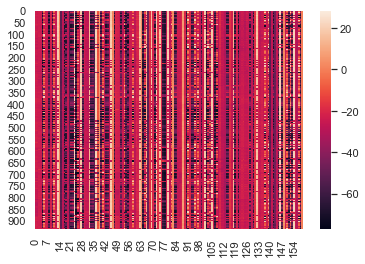

In [58]:
sns.heatmap(type_utilities - aug_old_utilities)

In [60]:
aug_old_utilities.shape

(931, 160)

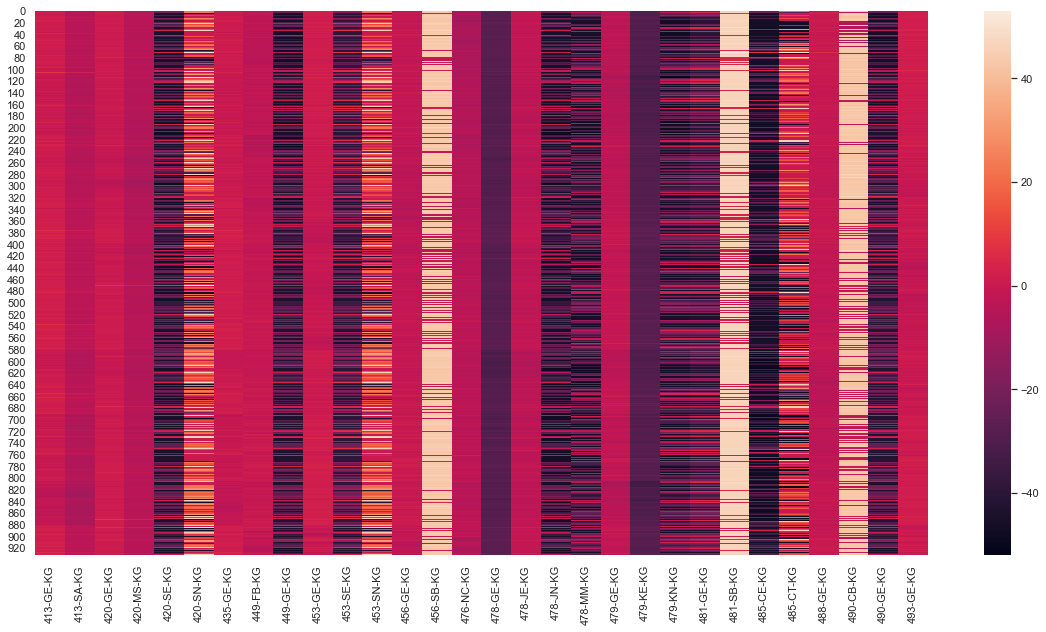

In [74]:
m = 30
plt.figure(figsize=(20,10))
sns.heatmap((type_utilities - old_utilities)[:, :m])
plt.xticks([i + .5 for i in range(m)], [idx2id[i] for i in range(m)], rotation=90)
plt.show()

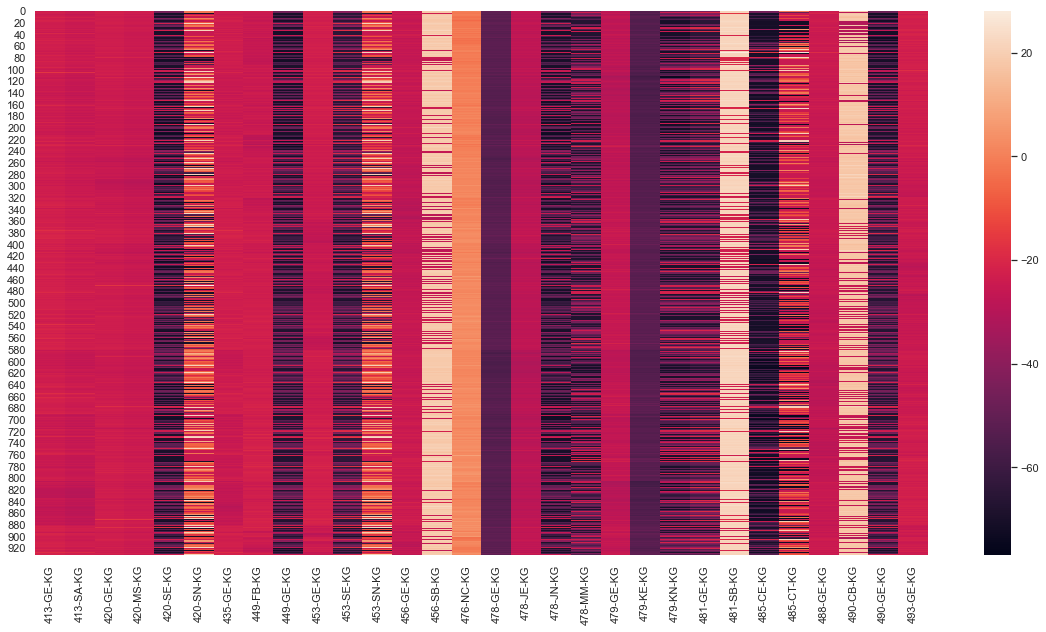

In [75]:
m = 30
plt.figure(figsize=(20,10))
sns.heatmap((type_utilities - aug_old_utilities)[:, :m])
plt.xticks([i + .5 for i in range(m)], [idx2id[i] for i in range(m)], rotation=90)
plt.show()

In [79]:
st.dropna(subset=["frl"]).sort_values("frl")[["frl", "census_blockgroup"]]

,frl,census_blockgroup
8732,0.0,6.075031e+10
9419,0.0,6.075025e+10
9422,0.0,6.075031e+10
6638,0.0,6.075031e+10
7874,0.0,6.075016e+10
...,...,...
12310,1.0,6.075016e+10
8410,1.0,6.075018e+10
12417,1.0,6.075011e+10
8040,1.0,6.075062e+10


In [8]:
siblings

,studentno
0,10210006
1,10212575
2,10216394
3,10216453
4,10216574
...,...
1185,10242700
1186,10242008
1187,10242706
1188,888008843


## Post Choice Metrics, Separating Out Siblings

In [12]:
import glob

In [14]:
dists = pd.read_csv("/Users/katherinementzer/Documents/sfusd/local_runs/Data/Precomputed/student_program_distances_dropoptout_1819.csv", index_col=0)

In [11]:
dists

,413-GE-KG,413-SA-KG,420-GE-KG,420-MS-KG,420-SE-KG,420-SN-KG,435-GE-KG,449-FB-KG,449-GE-KG,453-GE-KG,...,859-GE-KG,862-CB-KG,862-GE-KG,867-CB-KG,867-GE-KG,872-CB-KG,872-GE-KG,876-CE-KG,876-CN-KG,876-GE-KG
studentno,,,,,,,,,,,,,,,,,,,,,
10210005,4.473374,4.473374,3.384466,3.384466,3.384466,3.384466,3.951158,5.701885,5.701885,5.019194,...,5.513035,1.675126,1.675126,3.880911,3.880911,6.987676,6.987676,1.921483,1.921483,1.921483
10210006,6.380952,6.380952,3.290596,3.290596,3.290596,3.290596,5.772333,4.248004,4.248004,0.824518,...,4.727517,5.484468,5.484468,0.387022,0.387022,5.801425,5.801425,3.844362,3.844362,3.844362
10210007,2.159396,2.159396,1.841366,1.841366,1.841366,1.841366,1.855577,2.009324,2.009324,5.228952,...,1.258508,4.295509,4.295509,4.997587,4.997587,2.515562,2.515562,2.831248,2.831248,2.831248
10210010,2.741758,2.741758,0.415018,0.415018,0.415018,0.415018,2.170503,2.329250,2.329250,4.077301,...,2.041698,3.446032,3.446032,3.638238,3.638238,3.516507,3.516507,1.600115,1.600115,1.600115
10210039,5.082246,5.082246,2.959895,2.959895,2.959895,2.959895,4.482379,5.094352,5.094352,3.582217,...,5.125863,3.009039,3.009039,2.409244,2.409244,6.551905,6.551905,2.142958,2.142958,2.142958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888022985,5.131228,5.131228,2.250961,2.250961,2.250961,2.250961,4.511612,3.928583,3.928583,2.185731,...,4.161934,4.033820,4.033820,1.200044,1.200044,5.471858,5.471858,2.424157,2.424157,2.424157
888022990,4.897837,4.897837,3.083206,3.083206,3.083206,3.083206,4.316363,5.308858,5.308858,4.060572,...,5.267046,2.582724,2.582724,2.894940,2.894940,6.718336,6.718336,2.010533,2.010533,2.010533
888022996,4.630085,4.630085,2.549501,2.549501,2.549501,2.549501,4.027605,4.741816,4.741816,3.628875,...,4.728295,2.725779,2.725779,2.513839,2.513839,6.169357,6.169357,1.687943,1.687943,1.687943


In [13]:
opt_name = "dist4_maxfrl0.9_alpha1_card0_umodelavg"
assignment_files = glob.glob(
    f"/Users/katherinementzer/Documents/sfusd/local_runs/assignments/Assignment_CTIP0_round_merged123_policy{opt_name}home_based_peng_tiesSTB_iteration*.csv"
)
assignments = pd.DataFrame()
for f in assignment_files:
    assignments = assignments.append(pd.read_csv(f))
assignments["unassigned"] = np.where(assignments.programno == 0, 1, 0)
assignments["top3"] = np.where(assignments["rank"] <= 3, 1, 0)
assignments["assigned_utility"] = assignments.apply(
    lambda x: x.assigned_utility if x.programno != 0 else np.nan, axis=1
)
assignments["distance"] = assignments.apply(
    lambda x: dists.loc[x.studentno, x.programcodes]
    if not pd.isna(x.programcodes)
    else np.nan,
    axis=1,
)

In [10]:
no_sib_assign = pd.merge(assignments, siblings, on="studentno", how="outer", indicator=True)
no_sib_assign = no_sib_assign[no_sib_assign['_merge'] == 'left_only']
sib_assign = siblings.merge(assignments, on="studentno", how="left")

NameError: name 'assignments' is not defined

In [19]:
no_sib_assign[["rank", "top3", "designation", "unassigned", "assigned_utility", "distance"]].mean()

rank                34.894733
top3                 0.441597
designation          0.102103
unassigned           0.164135
assigned_utility    -2.796328
distance             1.891585
dtype: float64

In [20]:
sib_assign[["rank", "top3", "designation", "unassigned", "assigned_utility", "distance"]].mean()

rank                3.164426
top3                0.834566
designation         0.000000
unassigned          0.004202
assigned_utility    0.384833
distance            1.346689
dtype: float64

In [15]:
pattern = "/Users/katherinementzer/Documents/sfusd/local_runs/assignments/Assignment_CTIP3D_round_merged0_policyMedium1zones+reserves_tiesSTB_iteration*.csv"
assignment_files = glob.glob(pattern)
assignments = pd.DataFrame()
for f in assignment_files:
    assignments = assignments.append(pd.read_csv(f))
assignments["unassigned"] = np.where(assignments.programno == 0, 1, 0)
assignments["top3"] = np.where(assignments["rank"] <= 3, 1, 0)
assignments["assigned_utility"] = assignments.apply(
    lambda x: x.assigned_utility if x.programno != 0 else np.nan, axis=1
)
assignments["distance"] = assignments.apply(
    lambda x: dists.loc[x.studentno, x.programcodes]
    if not pd.isna(x.programcodes)
    else np.nan,
    axis=1,
)

no_sib_assign = pd.merge(assignments, siblings, on="studentno", how="outer", indicator=True)
no_sib_assign = no_sib_assign[no_sib_assign['_merge'] == 'left_only']
sib_assign = siblings.merge(assignments, on="studentno", how="left")

In [25]:
no_sib_assign[["rank", "top3", "designation", "unassigned", "assigned_utility", "distance"]].mean()

rank                20.797115
top3                 0.532366
designation          0.113866
unassigned           0.019635
assigned_utility    -2.494561
distance             1.320295
dtype: float64

In [26]:
sib_assign[["rank", "top3", "designation", "unassigned", "assigned_utility", "distance"]].mean()

rank                6.016246
top3                0.872269
designation         0.027395
unassigned          0.008627
assigned_utility    0.478228
distance            1.218297
dtype: float64

<AxesSubplot:>

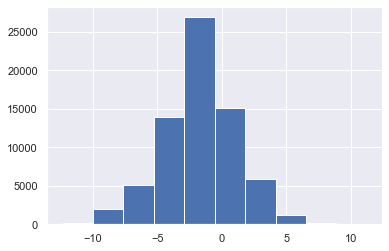

In [109]:
assignments.assigned_utility.hist()

In [16]:
sibs = siblings.merge(st.reset_index(drop=True).reset_index()).dropna(subset=["r1_ranked_idschool"])
sibs.r1_ranked_idschool = sibs.r1_ranked_idschool.apply(lambda x: eval(x))
sibs.sibling = sibs.sibling.apply(lambda x: eval(x))
sibs["sib_sch_rank"] = sibs.apply(lambda x: x.r1_ranked_idschool.index(x.sibling[0]) if x.sibling[0] in x.r1_ranked_idschool else np.nan, axis=1)

<AxesSubplot:>

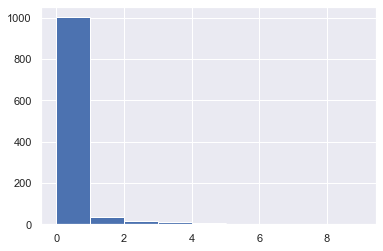

In [70]:
sibs.sib_sch_rank.hist(bins=range(10))

In [68]:
np.where(sibs.sib_sch_rank == 0,1,0).mean()

0.9294990723562152

In [57]:
# prefs = np.load("/Users/katherinementzer/Desktop/prefs_z+r.npy")
prefs = np.load("/Users/katherinementzer/Desktop/home_based_preferences.npy")

In [58]:
codes = pd.read_csv("/Users/katherinementzer/SFUSD/Data/program_codes.csv").rename(columns={"index":"programno"})
codes["school"] = codes.code.apply(lambda x: int(x[:3]))
code2idx = dict(zip(codes.code, codes.programno))
code2idxs = dict(codes.groupby("school").programno.agg(list))

In [59]:
sib_sch_rank = []
ranked_ge = []
for i, row in sibs.rename(columns={"index":"st_idx"}).iterrows():
    if len(np.where(prefs[int(row.st_idx)] == code2idx[f"{row.sibling[0]}-GE-KG"])[0]) > 1:
        print(prefs[int(row.st_idx),:])
        print(row.sibling)
        print(code2idx[f"{row.sibling[0]}-GE-KG"])
    ranked_ge.append(np.where(prefs[int(row.st_idx)] == code2idx[f"{row.sibling[0]}-GE-KG"])[0][0])
    ranks = np.where(np.isin(prefs[int(row.st_idx),:], code2idxs[row.sibling[0]]))[0]
    if len(ranks) > 0:
        sib_sch_rank.append(ranks[0])

In [60]:
np.where(np.array(sib_sch_rank) == 0, 1, 0).mean()

0.7708719851576994

In [61]:
np.where(np.array(ranked_ge) == 0, 1, 0).mean(), np.where(np.array(ranked_ge) < 3, 1, 0).mean()

(0.549165120593692, 0.849721706864564)

In [68]:
np.array(ranked_ge)[np.where(np.array(ranked_ge) >= 3)]

array([ 3,  4,  4,  4,  3,  6,  4, 21,  4,  7,  4,  3,  9, 10,  3,  5,  3,
        3,  3,  3,  3,  3,  3,  4,  3,  3,  4,  6,  3,  4,  3,  4,  9,  3,
        3,  3,  3, 10, 15, 13,  9,  3,  4,  6,  3,  4,  9, 19,  3,  4,  5,
        4, 15,  4,  3,  3,  6,  4,  3,  5, 21, 18, 11,  8,  5,  9,  3,  5,
        4, 15,  5,  3,  4, 10,  8,  7,  3,  7,  7, 10,  3,  6,  3,  6,  4,
        3,  4,  6,  3,  4,  3,  3,  4,  4,  3,  4,  4, 10,  3,  5,  3,  5,
       26, 12,  3,  8,  3,  4, 19,  5,  4,  5,  7,  4,  9, 18,  6,  3, 27,
        3, 27,  3,  4,  3, 21,  3,  4,  4,  3, 10,  3, 13,  3,  3,  6, 14,
        4,  6, 23,  7, 27,  8,  3,  3, 21, 15, 12, 10,  8,  3, 11,  3,  3,
        8,  4,  5, 13, 10,  5, 19,  8,  3])

In [41]:
assignment = pd.read_csv("/Users/katherinementzer/Documents/sfusd/local_runs/assignments/Assignment_CTIP0_round_merged0_policydist4_maxfrl1_alpha0.5_card0_umodelavghome_based_peng_tiesSTB_iteration0.csv")

In [42]:
sib_assignment = assignment.merge(siblings, how="inner")

In [43]:
len(sib_assignment)

1190

In [62]:
sib_assignment["rank"].mean()

10.972268907563025

In [45]:
sib_assignment

,studentno,programno,programcodes,rank,designation,assigned_utility,In-Zone Rank
0,10210006,93.0,729-GE-KG,1.0,0.0,2.374745,1
1,10210058,20.0,872-GE-KG,7.0,0.0,-2.702276,1
2,10210160,74.0,676-GE-KG,1.0,0.0,0.408686,1
3,10210205,155.0,876-GE-KG,1.0,0.0,3.302011,1
4,10210214,130.0,834-GE-KG,3.0,0.0,-0.178638,1
...,...,...,...,...,...,...,...
1185,10242869,0.0,NaN,99.0,0.0,NaN,0
1186,888009715,0.0,NaN,131.0,0.0,NaN,0
1187,888021277,0.0,NaN,131.0,0.0,NaN,0
1188,888021301,0.0,NaN,99.0,0.0,NaN,0


In [63]:
len(sib_assignment.loc[sib_assignment.programno ==0])

89

In [64]:
sib_assignment.loc[sib_assignment["rank"] > 1].loc[sib_assignment.programno != 0]

,studentno,programno,programcodes,rank,designation,assigned_utility,In-Zone Rank
1,10210058,20.0,872-GE-KG,7.0,0.0,-2.702276,1
4,10210214,130.0,834-GE-KG,3.0,0.0,-0.178638,1
5,10210220,3.0,420-GE-KG,6.0,0.0,-0.226198,1
7,10210236,24.0,478-GE-KG,3.0,0.0,1.379500,1
11,10210349,155.0,876-GE-KG,5.0,0.0,-0.242394,1
...,...,...,...,...,...,...,...
1131,10242610,51.0,593-GE-KG,2.0,0.0,-2.266548,1
1148,10242921,130.0,834-GE-KG,2.0,0.0,0.241814,1
1156,888008168,53.0,453-GE-KG,8.0,0.0,-4.159093,1
1157,888008442,51.0,593-GE-KG,13.0,0.0,-2.953625,1


In [65]:
np.where(sib_assignment["rank"] <= 3, 1, 0).mean()

0.7655462184873949

How is it possible that 90 siblings are unassigned and 480 aren't getting their first choice, if essentially everyone is actually ranking it first? Are the sibling menus wrong? 

In [66]:
sib_assignment.loc[sib_assignment.studentno == 10216987]

,studentno,programno,programcodes,rank,designation,assigned_utility,In-Zone Rank
216,10216987,93.0,729-GE-KG,3.0,0.0,0.590369,1


In [67]:
prefs[869, :]

array([ 94.,  84.,  95., 117.,  93., 134., 101.,   3.,  74.,   5.,  69.,
        57.,  35., 155.,  59., 136., 143.,  20., 122.,  48.,  49.,  87.,
       111., 115., 107.,  34., 116.,   6.,  46.,  85.,  90.,  24.,  11.,
       113.,  28.,  41.,  98.,  99.,  76., 121.,  37.,  71.,  73.,  62.,
        39., 149.,  29., 128.,  82., 123.,  18.,  12., 127.,   7.,  40.,
       120.,  17., 132., 151., 145., 152., 142.,  88.,  61.,   8., 147.,
         9.,  14., 102., 114., 150.,  97.,  15., 118.,  32., 125.,  55.,
        52.,  80.,  13.,  54.,  51.,  45., 156.,   1.,  27., 110.,  64.,
        31., 124.,  86., 106.,  53.,  89.,  75., 112., 131., 100.,  30.,
       157., 139., 137.,  58.,  83.,  10., 126.,   2., 133., 130.,   4.,
        60.,  70.,  33.,  50., 135.,  81.,  79.,  67.,  47.,  42., 119.,
        63.,  91.,  16., 141.,  21.,  38.,  36.,  68., 144.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [70]:
real_match = pd.read_csv("/Users/katherinementzer/Documents/sfusd/local_runs/assignments/Assignment_real_match.csv")

In [71]:
sib_real = real_match.merge(siblings, how="inner", on="studentno")

In [74]:
sib_real["program_type"] = sib_real.programcodes.apply(lambda x: np.nan if pd.isna(x) else x[4:6])

In [75]:
sib_real.loc[sib_real.programno == 0]

,studentno,programno,programcodes,rank,designation,assigned_utility,In-Zone Rank,program_type
158,10216309,0.0,NaN,5.0,0.0,NaN,5.0,NaN
343,10218150,0.0,NaN,10.0,0.0,NaN,10.0,NaN
430,10219027,0.0,NaN,5.0,0.0,NaN,5.0,NaN
1057,888022694,0.0,NaN,2.0,0.0,NaN,2.0,NaN
1100,10242356,0.0,NaN,3.0,0.0,NaN,3.0,NaN
1126,10242581,0.0,NaN,6.0,0.0,NaN,6.0,NaN
1140,10242778,0.0,NaN,2.0,0.0,NaN,2.0,NaN
1141,10242797,0.0,NaN,3.0,0.0,NaN,3.0,NaN
1153,888006730,0.0,NaN,3.0,0.0,NaN,3.0,NaN


In [76]:
sib_real.loc[sib_real.program_type != "GE"].dropna(subset=["program_type"])

,studentno,programno,programcodes,rank,designation,assigned_utility,In-Zone Rank,program_type
0,10210006,94.0,729-SE-KG,1.0,0.0,-1.135439,1.0,SE
4,10210214,129.0,834-CB-KG,1.0,0.0,-0.159656,1.0,CB
5,10210220,6.0,420-SN-KG,1.0,0.0,0.446574,1.0,SN
7,10210236,25.0,478-JE-KG,1.0,0.0,3.224584,1.0,JE
11,10210349,153.0,876-CE-KG,1.0,0.0,-1.749898,1.0,CE
...,...,...,...,...,...,...,...,...
1181,10241373,116.0,760-SN-KG,1.0,0.0,1.791210,1.0,SN
1182,10241429,79.0,691-FB-KG,1.0,0.0,-3.426895,1.0,FB
1183,10241489,131.0,834-SB-KG,1.0,0.0,1.326607,1.0,SB
1184,10241499,152.0,497-SN-KG,1.0,0.0,-2.091721,1.0,SN


In [77]:
len(sib_real.loc[sib_real.program_type != "GE"])/len(sib_real)

0.29411764705882354

In [78]:
sib_real["rank"].mean()

1.1764705882352942

In [79]:
sib_real = sib_real.merge(st[["studentno", "sibling"]], how="left")

In [87]:
sib_real

,studentno,programno,programcodes,rank,designation,assigned_utility,In-Zone Rank,program_type,sibling,sib_assigned
0,10210006,94.0,729-SE-KG,1.0,0.0,-1.135439,1.0,SE,[729],True
1,10210058,20.0,872-GE-KG,1.0,0.0,-0.353458,1.0,GE,[872],True
2,10210160,74.0,676-GE-KG,1.0,0.0,2.738527,1.0,GE,[676],True
3,10210205,155.0,876-GE-KG,1.0,0.0,1.735381,1.0,GE,[876],True
4,10210214,129.0,834-CB-KG,1.0,0.0,-0.159656,1.0,CB,[834],True
...,...,...,...,...,...,...,...,...,...,...
1185,10242869,73.0,490-GE-KG,1.0,0.0,-1.163987,1.0,GE,[490],True
1186,888009715,14.0,449-GE-KG,1.0,0.0,-3.873060,1.0,GE,[449],True
1187,888021277,121.0,656-GE-KG,1.0,0.0,-3.944869,1.0,GE,[656],True
1188,888021301,30.0,525-GE-KG,1.0,0.0,-1.702687,1.0,GE,[525],True


In [85]:
sib_real["sib_assigned"] = sib_real.apply(
    lambda x: np.isin(int(x.programcodes[:3]), eval(x.sibling)) if not pd.isna(x.programcodes) else False, axis=1
)

In [88]:
sib_real.sib_assigned.astype(int).mean()

0.9588235294117647

In [94]:
len(sib_real.loc[sib_real["sib_assigned"].astype(int) == 0])

49